# Remove long term trends in lightcurves via EMD

**Introduction** 


* This notebook presents an example of how **empirical mode decomposition (EMD)** could be used as an alternative to the Savitzky-Golay filter to approximate low frequency trends in lightcurves.


* One of the advantages of the EMD-based method over the Savitzky-Golay filtering technique is that the former can be considered as an (almost) parameter-free approach, while the latter requires the specification of the window length and break tolerance parameters, for instance.


* The rationale for EMD trend filtering is discussed in [1]. The approach can be made parameter free thanks to the unique characteristics of the basis functions returned by the EMD (i.e., the so-called intrinsic mode functions or IMFs) and how the IMF energy behave in the presence of low-frequency trends (for more details, see [1])

Doug Souza, March 2020

[1] "Trend Filtering via Empirical Mode Decompositions", Azadeh Moghtaderi, Patrick Flandrin, Pierre Borgnat, Computational Statistics & Data Analysis, Volume 58, Pages 114–126, February 2013.

**First step** 

* First, let's create a dictionary and manually input data of some known targets and their status (i.e., confirmed hosting star or false positive). Data and information about targets can be retreived on http://archive.stsci.edu/kepler/data_search/search.php


In [1]:
# Creating dictionary with star information (id, status: confirmed/false positive, cadence, etc.)
dict_star_info = {
    'star_ids': [2571238, 3231341, 2166206, 1722276], 
    'status': ['Confirmed', 'Confirmed', 'False positive', 'False positive'],
    'cadence': ['long', 'long', 'long', 'long'],
    'time_vector': [], # to further append downloaded data
    'flux_vector': [], # to further append downloaded data
    'approximated_trend': [], # to further append computed data
    'detrended_series': [] # to further append computed data
}

**Second step** 

* Now, we download lightcurve data (post-PDC correction) using the <a href="https://docs.lightkurve.org/">lightcurve package</a>

* Data can also be downloaded via boto module from AWS S3 buckets (see <a href="https://registry.opendata.aws/kepler/">here</a>). Other jupyter notebook tutorial will be prepared on how to use boto.

In [2]:
# Importing necessary modules
from lightkurve import search_lightcurvefile

# Defining input parameters
chosen_quarter = 1 # quarter of interest

# Gathering lightcurves of considered cases
for i_id in range(0,len(dict_star_info['star_ids'])):

    current_star_id = dict_star_info['star_ids'][i_id]
    current_status = dict_star_info['status'][i_id]
    current_cadence = dict_star_info['cadence'][i_id]
    
    # Downloading data and returning a KeplerLightCurveFile
    lcf = search_lightcurvefile(target = 'KIC' + str(current_star_id), cadence = current_cadence, quarter = chosen_quarter).download()  
    
    # Get only curves that already passed through PDC module
    lcf_PDC = lcf.PDCSAP_FLUX
    
    # Filtering nans and outliers
    lcf_PDC = lcf_PDC.remove_nans().remove_outliers()
    
    # Storing respective flux and time vectors in the dictionary
    dict_star_info['time_vector'].append(lcf_PDC.time)
    dict_star_info['flux_vector'].append(lcf_PDC.flux)

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


**Third step** 

* Having downloaded the lightcurve datasets we will now use EMD to filter the trends from each individual lightcurve.

* To do so, let's initialize the ML_and_stat_tools() class, with ML and statistical methods to process/analyze lightcurve data

In [3]:
# Initializing data analysis module
from lightcurve_analysis import ML_and_stat_tools
ML_and_stat_tools_initialized = ML_and_stat_tools()

**Fourth step** 

* Now, we loop over all available time series and compute their corresponding detrended counterparts with the EMD-based method

In [4]:
lightcurves_to_consider = dict_star_info['flux_vector']
for my_lightcurve in lightcurves_to_consider:
    
    # Computing trend and detrended signal via empirical mode decomposition
    trend_component, detrended_time_series = ML_and_stat_tools_initialized.trends_by_EMD(my_lightcurve)
    
    # Appending approximated trend and detrended time series
    dict_star_info['approximated_trend'].append(trend_component)
    dict_star_info['detrended_series'].append(detrended_time_series)

**Fifth step** 

* Having estimate the trend components, let's plot the detrended time series to check the results!


* We can also evaluate the detrending that we just carried out by computing importance of the trend statistics (see [2] and [3])

[2] https://www.sciencedirect.com/science/article/abs/pii/S0165168417303171

[3] https://ieeexplore.ieee.org/document/6853610


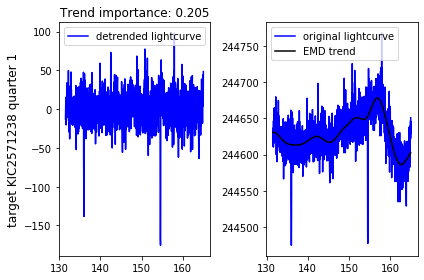

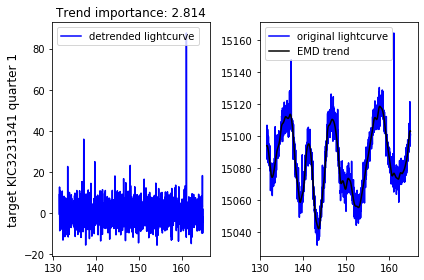

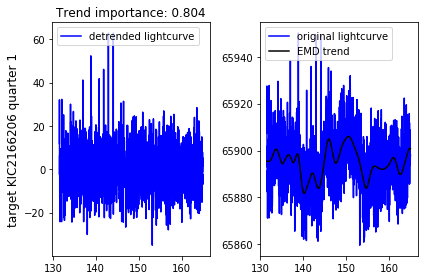

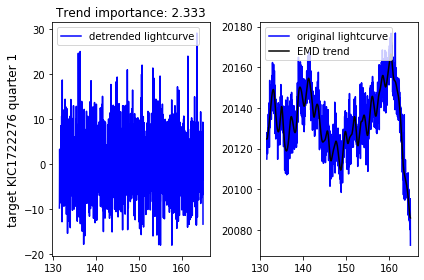

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Looping through all considered lighcurves and plot detrended time series
for i_id in range(0,len(dict_star_info['star_ids'])):

    # Evaluate the detrending: compute trend importance
    trend_importance = np.nanvar(dict_star_info['time_vector'][i_id])/np.nanvar(dict_star_info['detrended_series'][i_id])
    
    figure, axes = plt.subplots(nrows=1, ncols=2)

    ax1 = plt.subplot(121)
    plt.plot(dict_star_info['time_vector'][i_id],dict_star_info['detrended_series'][i_id],'b',label='detrended lightcurve')
    plt.ylabel('target KIC' + str(dict_star_info['star_ids'][i_id]) + ' quarter ' + str(chosen_quarter), fontsize=12)
    plt.legend(loc="upper left")
    plt.title('Trend importance: %.3f' %(trend_importance))

    plt.subplot(122)
    plt.plot(dict_star_info['time_vector'][i_id],dict_star_info['flux_vector'][i_id],'b',label='original lightcurve')
    plt.plot(dict_star_info['time_vector'][i_id],dict_star_info['approximated_trend'][i_id],'k',label='EMD trend')
    plt.legend(loc="upper left")

    figure.tight_layout()

